# Classifying Air Jordan Sneakers
## Sampson Mao

In [1]:
%reload_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import utils
from PIL import Image
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Finding Valid Images

The images appear to be scraped from the web. Upon further inspection, the "corrupted" data were html files. Here, I remove those files while making sure the files that are actually images have the right color mode.

In [4]:
IMAGE_DIR = "C:\\Users\\Sampson\\Desktop\\projects\\jordans_classifier\\images"

In [5]:
for x in os.walk(IMAGE_DIR):
    os.makedirs(x[0].replace("images", "data"), exist_ok=True)
    os.makedirs(x[0].replace("images", "corrupted"), exist_ok=True)

for path, subdirs, files in os.walk(IMAGE_DIR):
    print("Sorting", path)
    for filename in files:
        img_path = os.path.join(path, filename)
        try:
            img = Image.open(img_path)
            save_path = img_path.replace("images", "data")
            if img.format in ["BMP", "GIF", "JPEG"]:
                converted_img = img.convert("RGB")
                converted_img.save(save_path)
            elif img.format == "PNG":
                converted_img = img.convert("RGBA")
                # Some pngs were saved with .jpg. This prevents saving with the same name as a 'corrupted' image.
                converted_img.save(save_path.replace(".jpg", ".png"))
            else:
                img.save(save_path)
        except:
            save_path = img_path.replace("images", "corrupted")
            shutil.copy(img_path, save_path)

Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\1
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\10
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\11
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\12
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\13
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\14
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\15
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\16
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\17
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\18
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\19
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\2
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\20
Sorting C:\

While we do have a sizable number of images for each kind of shoe, many of the images do not provide much variety. For example, AJ1s seem to have the same images cropped or zoomed differently. Ideally we would want to remove duplicates but as an initial exploration, we will try data augmentation.

### Exploring the Images

In [6]:
DATA_DIR = "C:\\Users\\Sampson\\Desktop\\projects\\jordans_classifier\\data"

In [7]:
img_path_list = []
img_path_dict = {str(i + 1): [] for i in range(21)}
for path, subdirs, files in os.walk(DATA_DIR):
    for filename in files:
        # List of all image paths
        img_path = os.path.join(path, filename)
        img_path_list.append(img_path)

        # Paths grouped by shoe
        shoe_number = img_path.split("\\")[-2]
        img_path_dict[shoe_number].append(img_path)

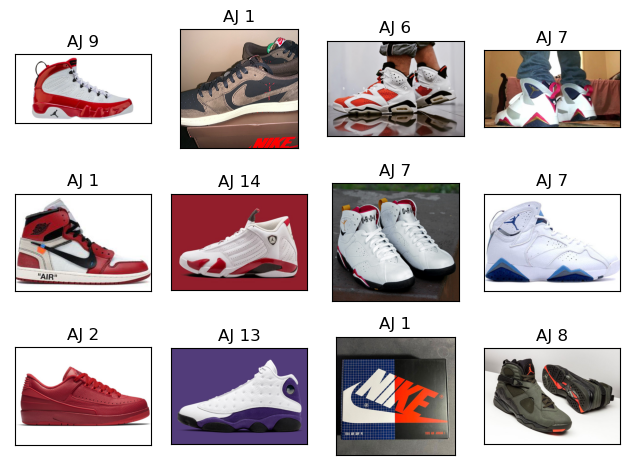

In [8]:
random.seed(10)

utils.show_random_set_of_shoes(img_path_list, 12, col_wrap=4)

In [ ]:
random.seed(10)

utils.show_shoe_series(img_path_dict, 1, 12, col_wrap=4)

### Modeling

There are many stock images in this dataset. In addition, some images are not of shoes (but a shoebox).

In [10]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
)

In [11]:
train_ds = datagen.flow_from_directory(
    DATA_DIR,
    subset="training",
    target_size=(256, 256, 3),
    class_mode="sparse",
)
val_ds = datagen.flow_from_directory(
    DATA_DIR,
    subset="validation",
    target_size=(256, 256, 3),
    class_mode="sparse",
)

Found 7504 images belonging to 21 classes.
Found 1867 images belonging to 21 classes.


Here I create a basic Sequential model with 2 convolutional layers.

In [12]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(21, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 dense (Dense)               (None, 64)                32000064  
                                                             

In [14]:
# model = tf.keras.Sequential(
#     [
#         tf.keras.layers.Conv2D(
#             filters=16, kernel_size=(3, 3), activation="relu", input_shape=(256, 256, 3)
#         ),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(512, activation="relu"),
#         tf.keras.layers.Dense(21, activation="softmax"),
#     ]
# )

Need to fill fourth dimension transparency with zeroes for RGB pictures

In [15]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [16]:
model.fit(train_ds, validation_data=val_ds, epochs=100)

ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256,3,3)

In [ ]:
model.save("./model1/")

In [ ]:
model.summary()

In [ ]:
model.predict(val_ds)